In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
color = sns.color_palette()
%matplotlib inline

#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

In [3]:
data = pd.read_csv('train.csv')
target = np.log1p(data['target'].values)

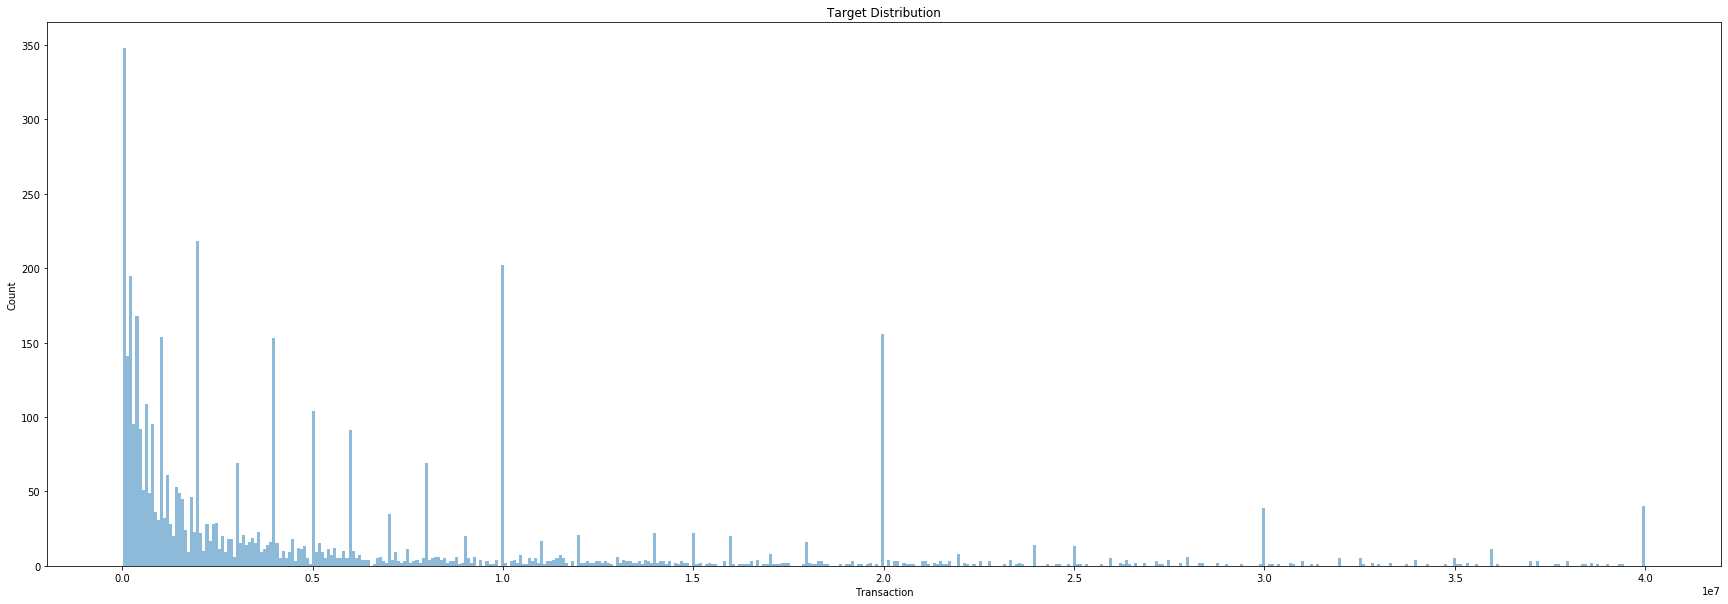

In [14]:
plt.figure(figsize=(30, 10))
plt.hist(data.target,bins=500, alpha = 0.5, histtype='bar') # Transactions tend to in X0000 (int)
plt.xlabel('Transaction')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

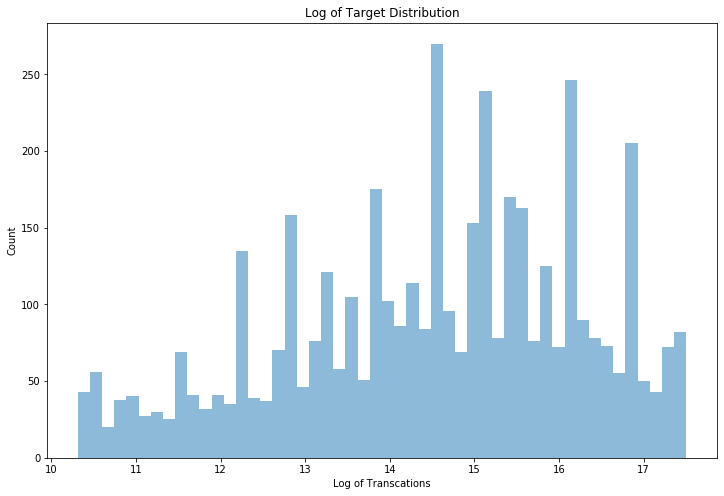

In [17]:
plt.figure(figsize=(12, 8))
plt.hist(target,bins=50, alpha = 0.5, histtype='bar') 
plt.xlabel('Log of Transcations')
plt.ylabel('Count')
plt.title('Log of Target Distribution')
plt.show()

In [21]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


In [31]:
data_unique = data.nunique().reset_index()
data_unique.columns = ['col_name', 'unique_count']
constant_col = data_unique.loc[data_unique['unique_count'] == 1,'col_name']
constant_col

28      d5308d8bc
35      c330f1a67
38      eeac16933
59      7df8788e8
70      5b91580ee
          ...    
4882    4600aadcf
4892    6fa0b9dab
4917    43d70cc4d
4931    408021ef8
4933    e29d22b59
Name: col_name, Length: 256, dtype: object

In [41]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

def spearmanr_cal(data):
    col_names = []
    values = []

    for col in data.columns:
        if col not in ['ID','target']:
            col_names.append(col)
            values.append(spearmanr(data[col].values,data.target.values)[0])

    corr_df = pd.DataFrame({'col_names':col_names,'corr_values':values})
    corr_df = corr_df.sort_values(by = 'corr_values')
    return corr_df

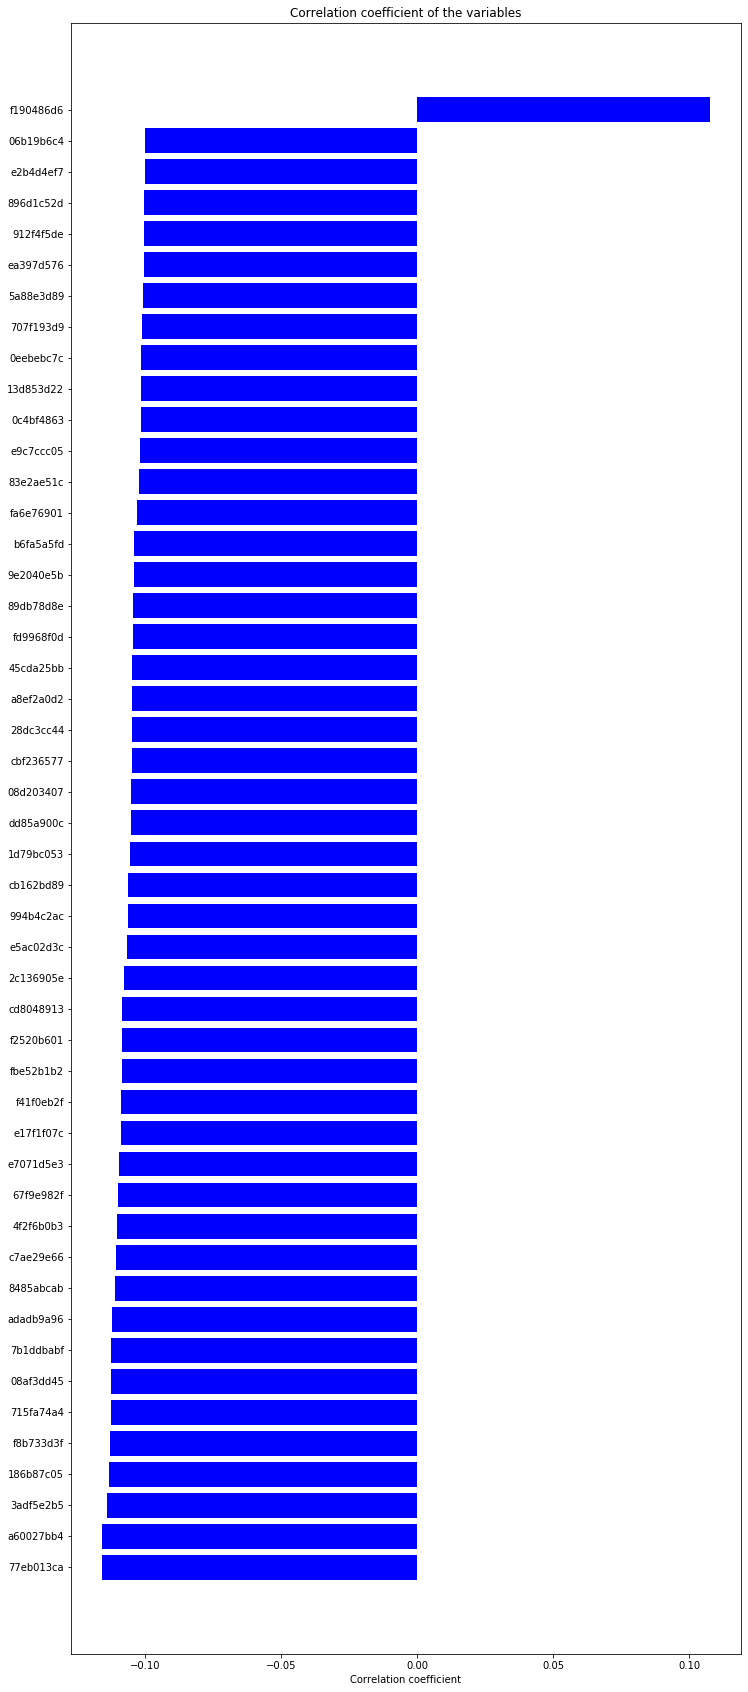

In [42]:
corr_df = spearmanr_cal(data)
high_corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values'] < -0.1)]
ind = np.arange(high_corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(high_corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(high_corr_df.col_names.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

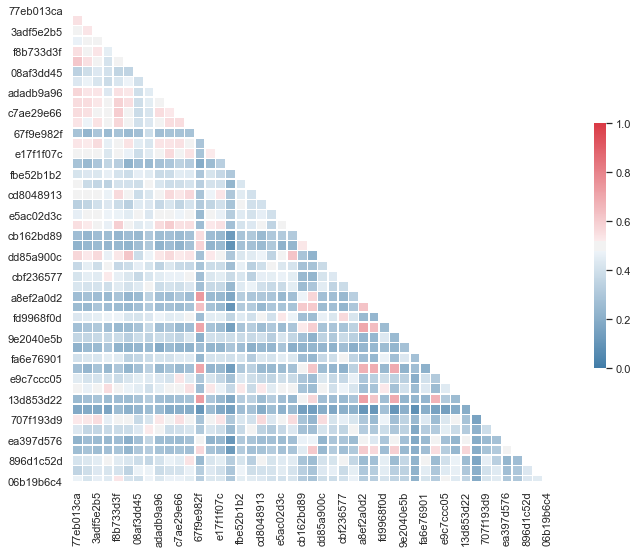

In [43]:
from string import ascii_letters
top_cor_feature = high_corr_df.col_names
sns.set(style="white")
# Compute the correlation matrix
corr_top = data[top_cor_feature].corr(method='spearman')
#corr_high = df[high_corr_col].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_top, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_top, mask=mask, cmap=cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [65]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
df = data.drop('target',axis=1).set_index('ID')
df = df.drop(constant_col,axis=1)
RANDOM_SEED = 137
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size= test_fraction, random_state=RANDOM_SEED)

best_params_ = {'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}
 
rf_best = RandomForestRegressor(**best_params_,
                                n_jobs = 8, random_state = RANDOM_SEED)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
                      oob_score=False, random_state=137, verbose=0,
                      warm_start=False)

In [1]:
feat_names = X_train.columns.values
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

NameError: name 'X_train' is not defined

In [ ]:
def prepare(data_orig):
    data = pd.DataFrame()
    data['mean'] = data_orig.mean(axis=1)
    data['std'] = data_orig.std(axis=1)
    data['min'] = data_orig.min(axis=1)
    data['max'] = data_orig.max(axis=1)
    data['number_of_different'] = data_orig.nunique(axis=1)               # Number of diferent values in a row.
    data['non_zero_count'] = data_orig.fillna(0).astype(bool).sum(axis=1) # Number of non zero values (e.g. transaction count)
    return data